!!! questions "Questions"  
    - How can we implement unsupervised learning techniques in python?
    
!!! objectives "Objectives"
    - To understand the difference between unsupervised and 
      supervised learning


<!--
---
title: "Unsupervised learning"
author: "Darya Vanichkina, Madhura Killedar"
keypoints:
- Unsupervised learning is an approach where we use machine learning to search for patterns in the data
- Clustering can help you identify groups in your data
questions:
- How can we implement unsupervised learning techniques in python?
objectives:
- To understand the difference between unsupervised and supervised learning
source: Rmd
teaching: 60
exercises: 30
---

-->

## Unsupervised learning

In [1]:
import warnings
warnings.simplefilter('ignore', category=UserWarning)
warnings.simplefilter('ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.utils import resample


# Set up plotting options for seaborn and matplotlib
sns.set_context('notebook') 
sns.set_style('ticks') 
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

## Dataset
We will be using the Iris dataset in order to demo unsupervised learning methods

In [2]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


There are three species (our target label)

In [3]:
iris['species'].unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [4]:
iris_features = iris.iloc[:, 0:4]
iris_target = iris.iloc[:,4]
print(iris_features.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2


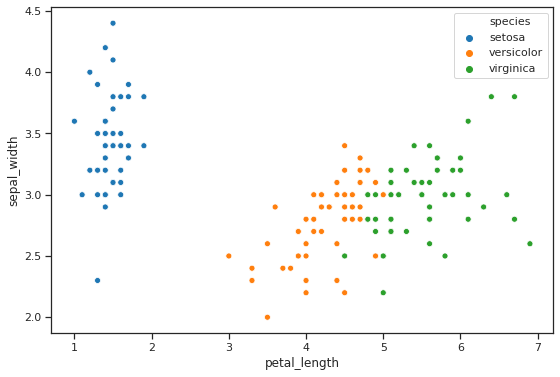

In [5]:
sns.scatterplot(x='petal_length',
                y='sepal_width', 
                data=iris, 
                hue=iris_target);

!!! challenge "Challenge 1"  
    1. Take a few moments to explore the Iris dataset. 
       What can you learn? Which species do you think 
       will be easier to separate?

## K-means clustering
K-means looks for a fixed number (k) of clusters in a dataset. The K-means algorithm:
- identifies k number of centroids
- allocates every data point to the nearest cluster, while keeping the centroids as small as possible.
- performs iterative (repetitive) calculations to optimize the positions of the centroids

### Scale data

In [6]:
iris_features_sc = RobustScaler().fit_transform(iris_features)

### Try 2 clusters

In [7]:
model_kmeans_k2 = KMeans(n_clusters=2, random_state=0)
labels_k2 = model_kmeans_k2.fit_predict(iris_features_sc)

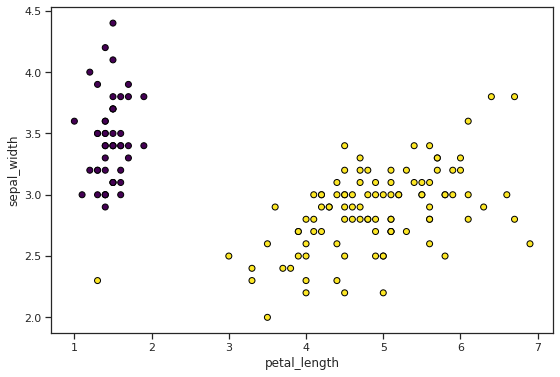

In [8]:
plt.scatter(iris['petal_length'], iris['sepal_width'], c=labels_k2, cmap='viridis', edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width');

### Try 3 clusters

In [9]:
model_kmeans_k3 = KMeans(n_clusters=3, random_state=42)
labels_k3 = model_kmeans_k3.fit_predict(iris_features_sc)
# [x[:2] for x in iris['species'].to_list()]

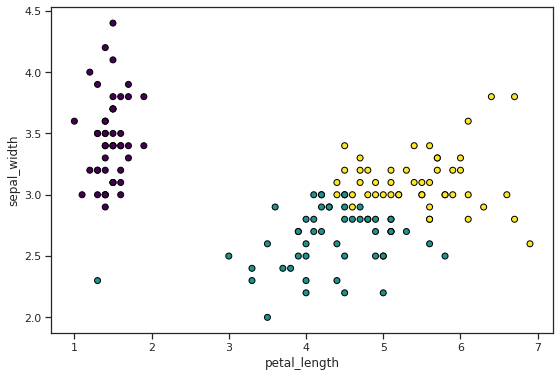

In [10]:
plt.scatter(iris['petal_length'], iris['sepal_width'], c=labels_k3, cmap='viridis', edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width');

!!! challenge "Challenge 2"  
    1. Choose whichever clustering approach you think worked best 
       among the above. If you partition the data this way, which 
       of the variables is most distinct in the clusters?

    ??? "Solution"
        
        ```python
        iris_clustered = iris.copy()
        iris_clustered['prediction'] = labels_k3
        iris_clustered.melt(
            id_vars=['prediction', 'species']
        ).groupby(
            ['prediction','variable']
        ).mean()
        ```


### Optimal number of clusters
One of the trickier tasks in clustering is identifying the appropriate number of clusters k.

In [11]:
from scipy.spatial.distance import cdist

k_range = np.arange(2,12)
silhouette_avgs = []
sum_squared_distances = []

for i, k in enumerate(k_range):
    model_kmeans = KMeans(n_clusters=k, random_state=2)
    label_kmeans = model_kmeans.fit_predict(iris_features_sc)
    silhouette_avgs.append(silhouette_score(iris_features_sc, label_kmeans))    
    sum_squared_distances.append(model_kmeans.inertia_)

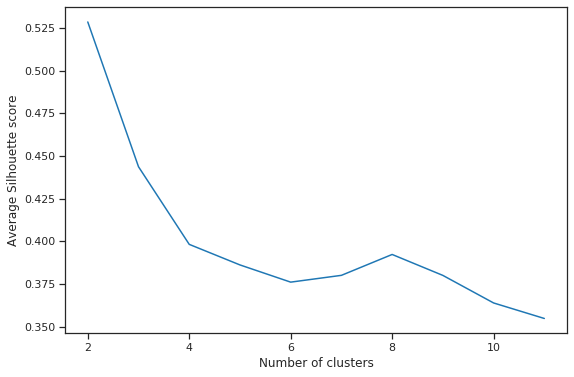

In [12]:
# Look for maximum
plt.plot(k_range, silhouette_avgs)
plt.ylabel('Average Silhouette score') 
plt.xlabel('Number of clusters');

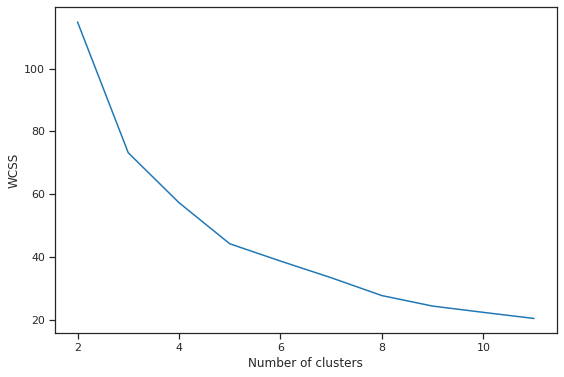

In [13]:
# look for elbow. Also known as Scree plot
plt.plot(k_range, sum_squared_distances)
plt.ylabel('WCSS') #within cluster sum of squared distances
plt.xlabel('Number of clusters');

## Hierarchical Clustering

The first step is to compute the distance between each sample, for which we will use the ward distance.

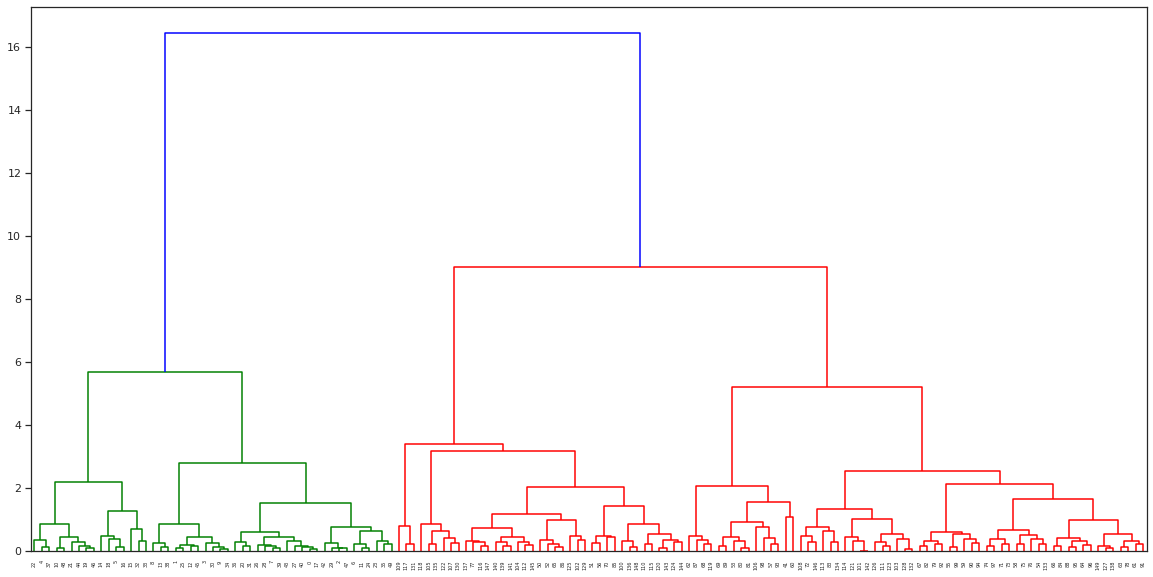

In [14]:
linked = linkage(iris_features_sc, method='ward')
f = plt.figure(figsize=(20, 10))
dendrogram(
    linked,  
    orientation='top',
    distance_sort='descending',
    show_leaf_counts=True
)
plt.show();

In [15]:
model_hclust = AgglomerativeClustering(n_clusters=3, linkage='ward')
iris_hc = model_hclust.fit(iris_features_sc)

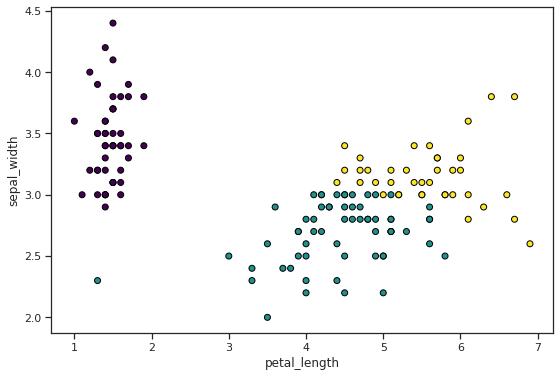

In [16]:
plt.scatter(iris['petal_length'], iris['sepal_width'], 
            c=model_hclust.labels_, 
            cmap='viridis', 
            edgecolor='k')
plt.xlabel('petal_length')
plt.ylabel('sepal_width');

### Plotting data

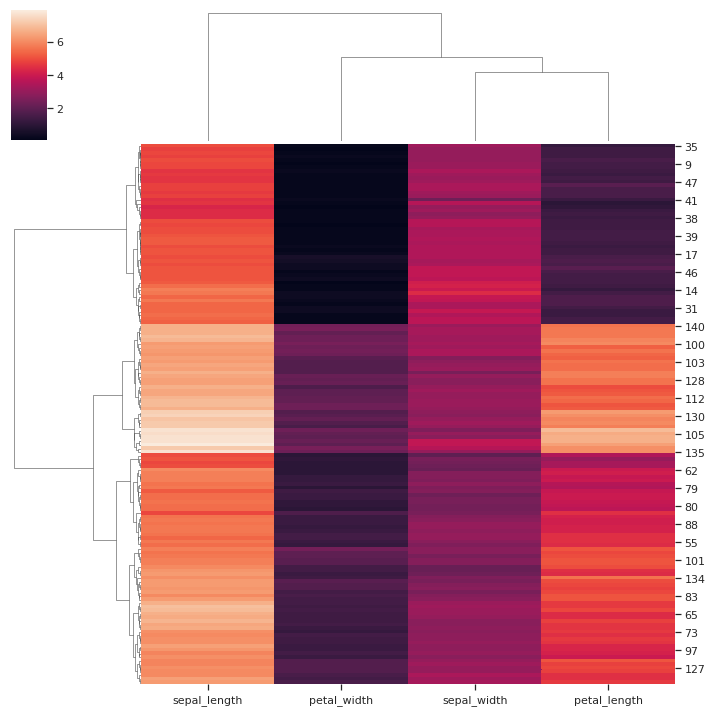

In [17]:
sns.clustermap(iris_features, method='ward');

!!! Challenge
    Try constructing a heatmap using another method, 
    and visualise the results.

    Do you think your approach is better or worse than the one 
    proposed in the notes? 
    Compare with your group…

    ??? "Solution"
        Compare with your neighbour

## Principal Component Analysis (PCA)

In [18]:
nPCs = 3
PCnames = ['PC1','PC2','PC3']
iris_pca = PCA(n_components=nPCs)
iris_reduced = iris_pca.fit_transform(iris_features)

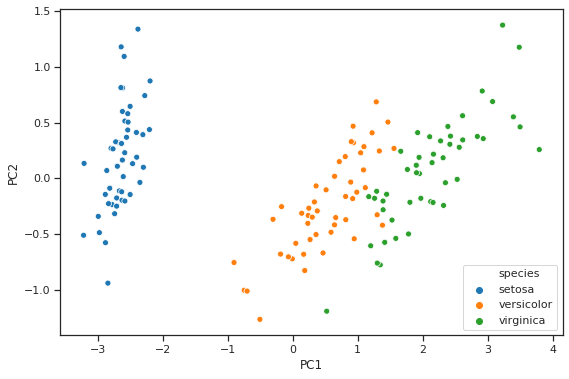

In [19]:
iris_PC_df = pd.DataFrame(iris_reduced, columns = PCnames)
sns.scatterplot(x='PC1',y='PC2', data=iris_PC_df, hue=iris_target);

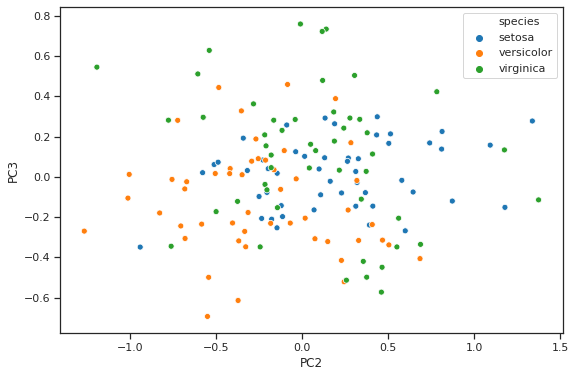

In [20]:
sns.scatterplot(x='PC2', y='PC3', data=iris_PC_df, hue=iris_target);

### Eigenvalues

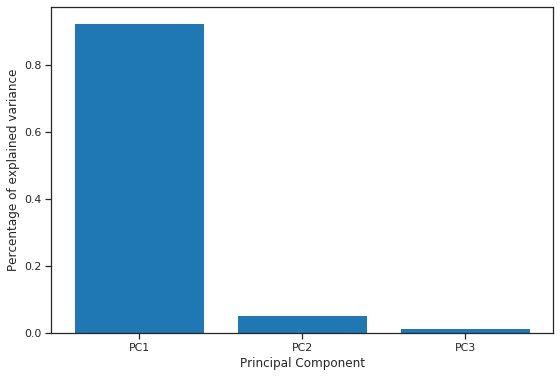

In [21]:
iris_eig = iris_pca.explained_variance_ratio_

x = np.arange(nPCs)
fig, ax = plt.subplots()
plt.bar(x, iris_eig)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Component')
plt.xticks(x, PCnames);

In [22]:
iris_comp = iris_pca.components_
iris_comp

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102],
       [-0.58202985,  0.59791083,  0.07623608,  0.54583143]])

In [23]:
df_iris_comp = pd.DataFrame(iris_comp, columns=iris.columns.drop('species'), index=PCnames)
df_iris_comp

,sepal_length,sepal_width,petal_length,petal_width
PC1,0.361387,-0.084523,0.856671,0.358289
PC2,0.656589,0.730161,-0.173373,-0.075481
PC3,-0.582030,0.597911,0.076236,0.545831


In [24]:
df_iris_comp.T

,PC1,PC2,PC3
sepal_length,0.361387,0.656589,-0.582030
sepal_width,-0.084523,0.730161,0.597911
petal_length,0.856671,-0.173373,0.076236
petal_width,0.358289,-0.075481,0.545831


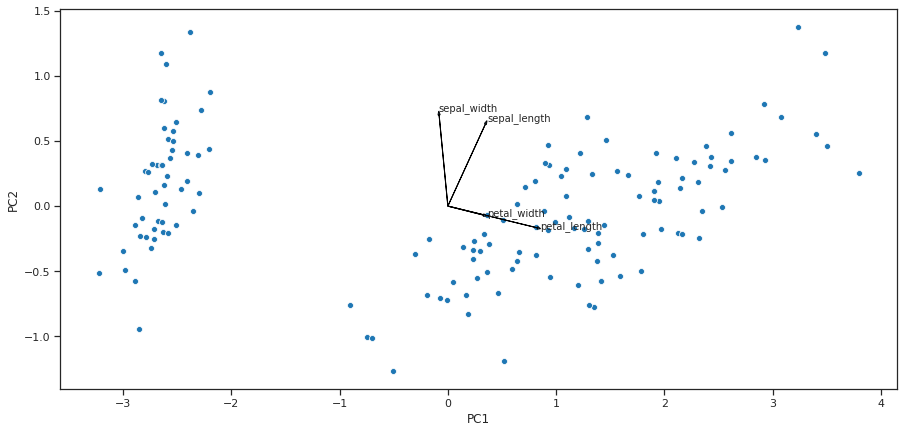

In [25]:
f = plt.figure(figsize=(15, 7))
ax = plt.axes()
for idx in range(df_iris_comp.T.index.shape[0]):
    ax.arrow(
        0, 0, 
        df_iris_comp.T['PC1'][idx], 
        df_iris_comp.T['PC2'][idx], 
        head_width=0.02, ec='k',
        length_includes_head=True,
    )
    ax.annotate(df_iris_comp.columns[idx], 
                xy=(df_iris_comp.T['PC1'][idx], 
                    df_iris_comp.T['PC2'][idx]))
sns.scatterplot(x='PC1', y='PC2', data=iris_PC_df);

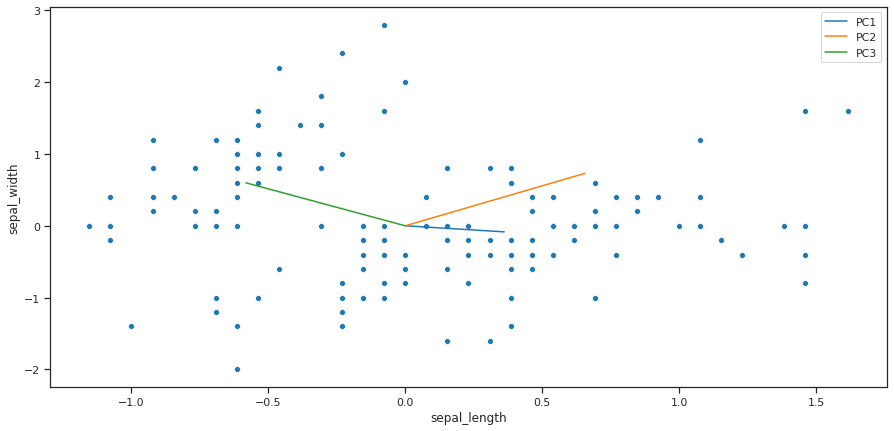

In [26]:
iris_scaled = pd.DataFrame(iris_features_sc, columns=iris_features.columns)

f = plt.figure(figsize=(15, 7))

for pc in np.arange(nPCs):
    plt.plot([0, iris_comp[pc, 0]], [0,iris_comp[pc,1]], 
             label=PCnames[pc])
plt.xlabel(iris_features.columns[0])
plt.ylabel(iris_features.columns[1])
sns.scatterplot(x='sepal_length', y='sepal_width', data=iris_scaled)
plt.legend();

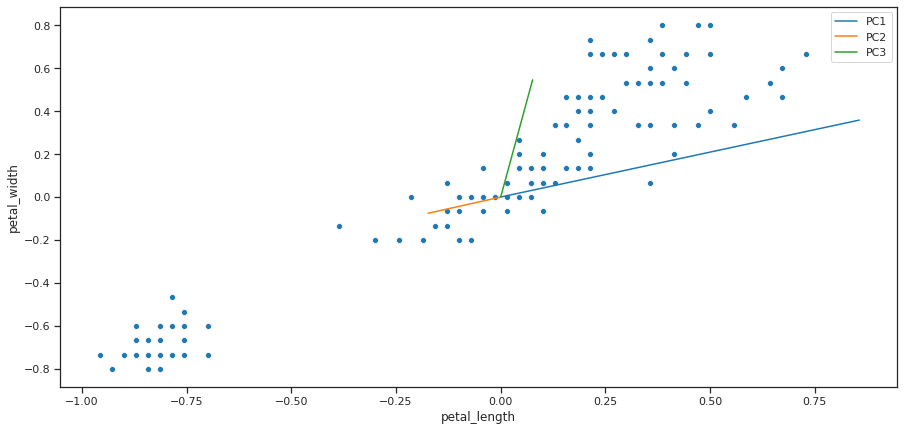

In [27]:
f = plt.figure(figsize=(15, 7))

for pc in np.arange(nPCs):
    plt.plot([0,iris_comp[pc,2]], [0,iris_comp[pc,3]], label=PCnames[pc])
plt.xlabel(iris_features.columns[2])
plt.ylabel(iris_features.columns[3])
sns.scatterplot(x='petal_length', y='petal_width', data=iris_scaled)
plt.legend();

If you need to generate more/better visualisations and exploration of your PCA outcome, R has much better "out of the box" visualisations to help you understand what is going on. See [here](https://pages.github.sydney.edu.au/informatics/lessons-mlr/90-Unsupervised.html) for our code for doing this on the iris dataset.

In [28]:
model_tsne = TSNE(n_components=2, perplexity=25, random_state=42)
iris_tsne = model_tsne.fit_transform(iris_features)

In [29]:
iris_tsne_df = pd.DataFrame(iris_tsne, columns = ['Dim1','Dim2'])
iris_tsne_df.head()

,Dim1,Dim2
0,-17.846640,-19.192671
1,-21.286514,-20.214451
2,-21.429764,-18.782772
3,-21.803328,-19.113916
4,-18.029144,-18.821222


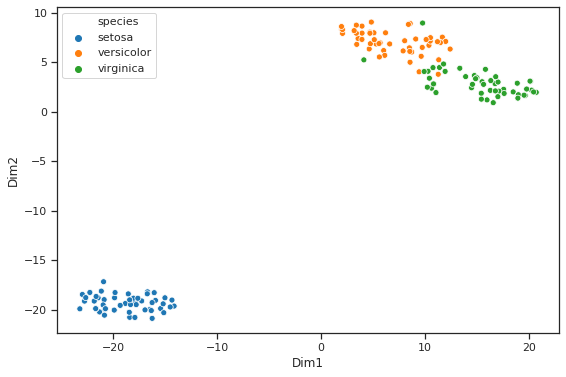

In [30]:
sns.scatterplot(x='Dim1',y='Dim2', data=iris_tsne_df, hue=iris_target);

!!! keypoints "Key points"  
    - Unsupervised learning is an approach where we use machine 
      learning to search for patterns in the data
    - Clustering can help you identify groups in your data